In [94]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

In [95]:
df = pd.read_excel('Mark.xlsx', index_col = 0)
df

,Cnsmr,Manuf,HiTec,Hlth,Other
198001,0.0397,0.0874,0.0403,-0.0140,0.0527
198002,-0.0603,0.0305,-0.0394,-0.0528,-0.0368
198003,-0.0875,-0.1407,-0.0958,-0.0298,-0.1274
198004,0.0279,0.0584,0.0303,0.0415,0.0582
198005,0.0689,0.0422,0.0363,0.0634,0.0767
...,...,...,...,...,...
201804,0.0099,0.0121,-0.0060,-0.0038,0.0037
201805,0.0038,0.0204,0.0560,0.0219,0.0101
201806,0.0310,-0.0001,0.0047,0.0143,-0.0114
201807,0.0263,0.0328,0.0223,0.0600,0.0390


## Returns, Standard Deviation and Covariance Matrix of the 5 industries

In [96]:
df_ind_rets = df.mean()*12
df_ind_rets

Cnsmr    0.117222
Manuf    0.089736
HiTec    0.110941
Hlth     0.122625
Other    0.101545
dtype: float64

In [97]:
df_ind_std = df.std() * (12**0.5)
df_ind_std

Cnsmr    0.147453
Manuf    0.147701
HiTec    0.198928
Hlth     0.158425
Other    0.176133
dtype: float64

In [98]:
cov_matrix = df.cov() * 12
cov_matrix

,Cnsmr,Manuf,HiTec,Hlth,Other
Cnsmr,0.021742,0.016451,0.021177,0.017020,0.022361
Manuf,0.016451,0.021816,0.019670,0.013982,0.020993
HiTec,0.021177,0.019670,0.039572,0.018540,0.025276
Hlth,0.017020,0.013982,0.018540,0.025099,0.019146
Other,0.022361,0.020993,0.025276,0.019146,0.031023


## Equally wieghted portfolio

In [99]:
eq_weights = np.array((0.2, 0.2, 0.2, 0.2, 0.2))
eq_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [100]:
eq_weights_ret = round(sum(eq_weights*df_ind_rets), 4)
eq_weights_std = round((eq_weights @ cov_matrix @ np.transpose(eq_weights))**0.5, 4)
print('Portfolio Return:', eq_weights_ret, '- Portfolio Standard Deviation:', eq_weights_std)

Portfolio Return: 0.1084 - Portfolio Standard Deviation: 0.1454


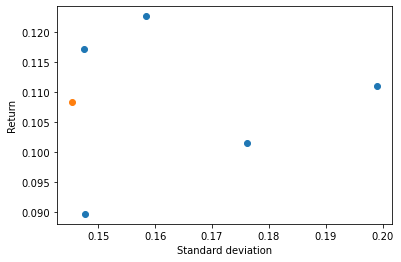

In [101]:
plt.scatter(df_ind_std, df_ind_rets)
plt.scatter(eq_weights_std, eq_weights_ret)
plt.xlabel('Standard deviation')
plt.ylabel('Return');

## Optimization

In [110]:
#Define an initial guess for x 
x = np.array((0.2, 0.2, 0.2, 0.2, 0.2))
x

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [111]:
# Create a variable with the arguments of the objective funtion
args = (cov_matrix,)

In [112]:
# Set the bounds
bounds = Bounds(-2, 2)

In [113]:
# Define the objective function
def objective_function(x, cov_matrix):
    return (x @ cov_matrix @ np.transpose(x))**0.5

In [160]:
# Define the constraints (if you want to find the Global Minimum Variance Portfolio comment the second constraint)
constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
               #{'type':'eq', 'fun': lambda x: sum(x*df_ind_rets)- 0.07}
              )

In [161]:
# Use scipy optimizer to find the minimum
res = optimize.minimize(objective_function, x, args=args, method='SLSQP', constraints=constraints, bounds=bounds)

In [162]:
res

     fun: 0.12982454398940707
     jac: array([0.12985932, 0.12985124, 0.12959572, 0.12971332, 0.12985212])
 message: 'Optimization terminated successfully'
    nfev: 90
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([ 0.54189385,  0.59670766, -0.05170353,  0.31852885, -0.40542684])

## Function creation and plotting

In [156]:
def min_std(x, cov_matrix, bounds, args, ret):
    def objective_function(x, cov_matrix):
        return (x @ cov_matrix @ np.transpose(x))**0.5
    
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type':'eq', 'fun': lambda x: sum(x*df_ind_rets) - ret}
              )
    
    res = optimize.minimize(objective_function, x, args=args, method='SLSQP', constraints=constraints, bounds=bounds)
    return res.fun

In [159]:
min_std(x, cov_matrix, bounds, args, ret=0.1099)

0.12984307123238625

In [68]:
opt_std = []
for i in np.arange(0.07, 0.15, 0.005):
    m = min_std(x, cov_matrix, bounds, args, ret=i)
    opt_std.append(m)

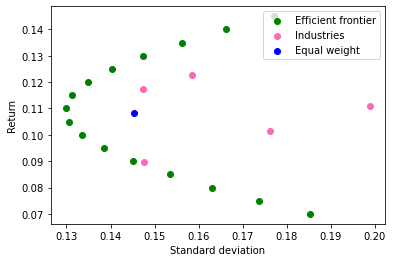

In [69]:
plt.scatter(opt_std, np.arange(0.07, 0.15, 0.005), c='green');
plt.scatter(df_ind_std, df_ind_rets, c='hotpink')
plt.scatter(eq_weights_std, eq_weights_ret, c='blue')
plt.xlabel('Standard deviation')
plt.ylabel('Return');
plt.legend(['Efficient frontier', 'Industries', 'Equal weight']);

## No short selling 

In [70]:
# Set the bounds
bnds_no_short = Bounds(0, 1)

In [71]:
# Define the constraints (if you want to find the Global Minimum Variance Portfolio comment the second constraint)
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type':'eq', 'fun': lambda x: sum(x*df_ind_rets) - 0.09}
        )

In [72]:
# Use scipy optimizer to find the minimum
res = optimize.minimize(objective_function, x, args=args, method='SLSQP', constraints=cons, bounds=bnds_no_short)

In [73]:
res

     fun: 0.1472796174380345
     jac: array([0.11172847, 0.14769795, 0.13349329, 0.09554162, 0.1424361 ])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.00000000e+00, 9.91979240e-01, 5.79843695e-18, 8.02075995e-03,
       0.00000000e+00])

## Two funds separation theorem

In [78]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
res = optimize.minimize(objective_function, x, args=args, method='SLSQP', constraints=cons, bounds=bounds)

In [163]:
GMVP = res.x